## a)
Daten aus der Zipdatei lesen

In [5]:
import zipfile
import json
from pathlib import Path

from tensorboard.notebook import display

path = Path('foods-2011-10-03.json.zip')

with zipfile.ZipFile(path, "r") as z:
    print("Inhalt des ZIP:", z.namelist())
    json_filename = None
    for name in z.namelist():
        if name.lower().endswith(".json"):
            json_filename = name
            break
    assert json_filename is not None, "Keine JSON-Datei im ZIP gefunden."

    with z.open(json_filename) as f:
        data = json.load(f)

print("Anzahl Einträge (Foods):", len(data))

Inhalt des ZIP: ['foods-2011-10-03.json']
Anzahl Einträge (Foods): 6636


## b)

Dataframes erstellen

In [10]:
import pandas as pd

# 1) info DataFrame erstellen
info_rows = []
for item in data:
    info_rows.append({
        "id": item.get("id"),
        "description": item.get("description"),
        "group": item.get("group"),
        "manufacturer": item.get("manufacturer")
    })
info = pd.DataFrame(info_rows)
display(info.head())

# 2) nutrients DataFrames
nutrient_dfs = []
for item in data:
    nid = item.get("id")
    nutlist = item.get("nutrients", [])
    if not nutlist:
        continue
    tmp = pd.DataFrame(nutlist)
    tmp["id"] = nid
    nutrient_dfs.append(tmp)

# Alle zu einem großen DataFrame zusammenfügen
nutrients = pd.concat(nutrient_dfs, ignore_index=True)
print("Größe nutrients (vor drop_duplicates):", nutrients.shape)
display(nutrients.head())

# Duplikate entfernen (falls gleiche Kombination id + description mehrfach)
nutrients_before = len(nutrients)
nutrients = nutrients.drop_duplicates()
print(f"Duplikate entfernt: {nutrients_before - len(nutrients)}")
print("Größe nutrients (nach drop_duplicates):", nutrients.shape)

# Umbenennen zur Eindeutigkeit:
nutrients = nutrients.rename(columns={
    "description": "nutrient_description",
    "group": "nutrient_group"
})
info = info.rename(columns={
    "description": "food_description",
    "group": "food_group"
})

# Merge (outer, damit nichts verloren geht)
merged = pd.merge(nutrients, info, on="id", how="outer", validate="m:1")
print("Merged shape:", merged.shape)
display(merged.head())

,id,description,group,manufacturer
0,1008,"Cheese, caraway",Dairy and Egg Products,
1,1009,"Cheese, cheddar",Dairy and Egg Products,
2,1018,"Cheese, edam",Dairy and Egg Products,
3,1019,"Cheese, feta",Dairy and Egg Products,
4,1028,"Cheese, mozzarella, part skim milk",Dairy and Egg Products,


Größe nutrients (vor drop_duplicates): (389355, 5)


,value,units,description,group,id
0,25.18,g,Protein,Composition,1008
1,29.20,g,Total lipid (fat),Composition,1008
2,3.06,g,"Carbohydrate, by difference",Composition,1008
3,3.28,g,Ash,Other,1008
4,376.00,kcal,Energy,Energy,1008


Duplikate entfernt: 14179
Größe nutrients (nach drop_duplicates): (375176, 5)
Merged shape: (375176, 8)


,value,units,nutrient_description,nutrient_group,id,food_description,food_group,manufacturer
0,25.18,g,Protein,Composition,1008,"Cheese, caraway",Dairy and Egg Products,
1,29.20,g,Total lipid (fat),Composition,1008,"Cheese, caraway",Dairy and Egg Products,
2,3.06,g,"Carbohydrate, by difference",Composition,1008,"Cheese, caraway",Dairy and Egg Products,
3,3.28,g,Ash,Other,1008,"Cheese, caraway",Dairy and Egg Products,
4,376.00,kcal,Energy,Energy,1008,"Cheese, caraway",Dairy and Egg Products,


## c)


Anzahl Zink-Einträge: 6137
Einige Zink-Einträge:


,nutrient_description,units,value,food_description,food_group
14,"Zinc, Zn",mg,2.94,"Cheese, caraway",Dairy and Egg Products
75,"Zinc, Zn",mg,3.11,"Cheese, cheddar",Dairy and Egg Products
151,"Zinc, Zn",mg,3.75,"Cheese, edam",Dairy and Egg Products
222,"Zinc, Zn",mg,2.88,"Cheese, feta",Dairy and Egg Products
293,"Zinc, Zn",mg,2.76,"Cheese, mozzarella, part skim milk",Dairy and Egg Products


Deskriptive Statistik (Zink in mg):
count    6137.000000
mean        2.228589
std         3.975321
min         0.000000
25%         0.340000
50%         0.980000
75%         2.980000
max        90.950000
Name: value_mg, dtype: float64


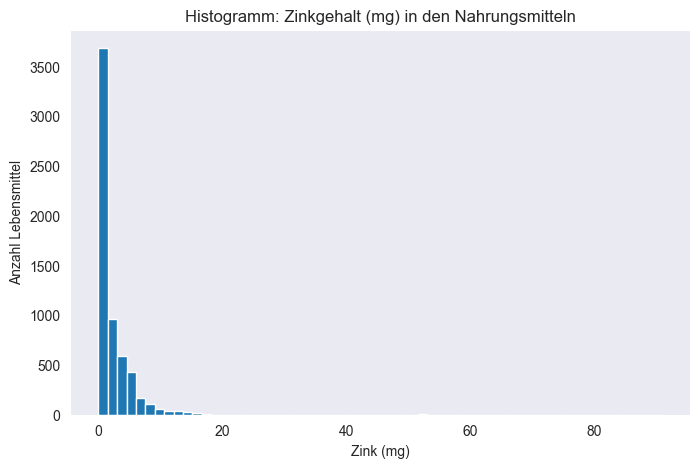

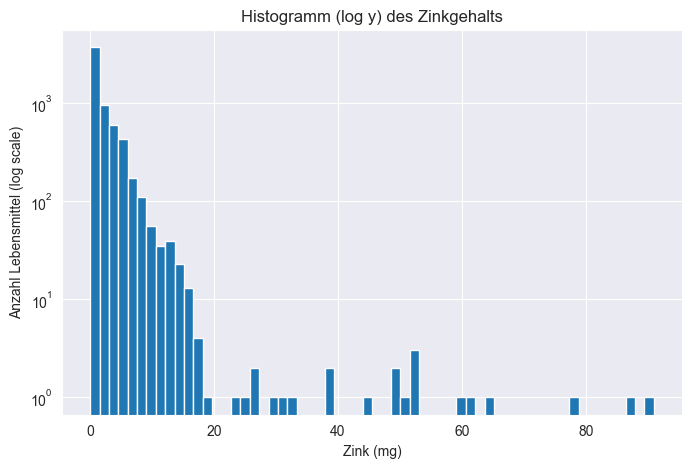

Gefundene Edam-Zeilen: 3
                   food_description  value_mg units
151                    Cheese, edam      3.75    mg
287494  Edamame, frozen, unprepared      1.32    mg
287560    Edamame, frozen, prepared      1.37    mg
Edam mean: 2.147 mg, Gesamtmean: 2.229 mg, Median: 0.980 mg, 75%-Quantil: 2.980 mg
Edam über dem Gesamtmean?: False
Edam max value_mg: 3.75
Edam größer als 75%-Quantil?: True
Maximaler Zinkgehalt:
food_description        Mollusks, oyster, eastern, canned
nutrient_description                             Zinc, Zn
value_mg                                            90.95
units                                                  mg
Name: 333726, dtype: object


In [15]:
mask_zinc = merged["nutrient_description"].str.contains("zinc", case=False, na=False)
zinc_df = merged[mask_zinc].copy()
print("Anzahl Zink-Einträge:", zinc_df.shape[0])
print("Einige Zink-Einträge:")
display(zinc_df[["nutrient_description", "units", "value", "food_description", "food_group"]].head())

# Einheit normalisieren: wir wollen mg als Basis (häufig ist units 'mg' aber prüfen)
zinc_df["units"].value_counts(dropna=False).head(10)

# Konvertionsfunktion: falls µg etc. (nur als Vorsichtsmaßnahme)
def to_mg(row):
    val = row["value"]
    units = row["units"] or ""
    units = units.lower()
    if pd.isna(val):
        return None
    if "mg" in units:
        return float(val)
    if "ug" in units or "µg" in units or "mcg" in units:
        return float(val) / 1000.0
    # Falls andere Units, try to parse number (fallback)
    return float(val)

zinc_df["value_mg"] = zinc_df.apply(to_mg, axis=1)

# Deskriptive Statistiken
desc = zinc_df["value_mg"].describe()
print("Deskriptive Statistik (Zink in mg):")
print(desc)

import matplotlib.pyplot as plt
plt.figure(figsize=(8,5))
zinc_df["value_mg"].hist(bins=60)
plt.xlabel("Zink (mg)")
plt.ylabel("Anzahl Lebensmittel")
plt.title("Histogramm: Zinkgehalt (mg) in den Nahrungsmitteln")
plt.grid(False)
plt.show()

# Histogramm log-scaled (wegen starker Schiefe)
plt.figure(figsize=(8,5))
plt.hist(zinc_df["value_mg"].dropna(), bins=60)
plt.yscale("log")
plt.xlabel("Zink (mg)")
plt.ylabel("Anzahl Lebensmittel (log scale)")
plt.title("Histogramm (log y) des Zinkgehalts")
plt.show()

mask_edam = zinc_df["food_description"].str.contains("edam", case=False, na=False)
edam_rows = zinc_df[mask_edam]
print("Gefundene Edam-Zeilen:", len(edam_rows))
if len(edam_rows) > 0:
    print(edam_rows[["food_description", "value_mg", "units"]])
    # Vergleich mit Durchschnitt / Perzentilen
    edam_mean_compare = edam_rows["value_mg"].mean()
    overall_mean = zinc_df["value_mg"].mean()
    overall_median = zinc_df["value_mg"].median()
    p75 = zinc_df["value_mg"].quantile(0.75)
    print(f"Edam mean: {edam_mean_compare:.3f} mg, Gesamtmean: {overall_mean:.3f} mg, Median: {overall_median:.3f} mg, 75%-Quantil: {p75:.3f} mg")

    # Ist Edam überdurchschnittlich?
    print("Edam über dem Gesamtmean?:", edam_mean_compare > overall_mean)
    edam_val = edam_rows["value_mg"].max()
    print("Edam max value_mg:", edam_val)
    print("Edam größer als 75%-Quantil?:", edam_val > p75)
else:
    print("Kein Edam gefunden. Prüfe food_description Inhalte (z.B. 'Cheese, edam').")

# Welches Lebensmittel hat maximalen Zinkgehalt?
idx_max = zinc_df["value_mg"].idxmax()
max_row = zinc_df.loc[idx_max]
print("Maximaler Zinkgehalt:")
print(max_row[["food_description", "nutrient_description", "value_mg", "units"]])


In [16]:
%load_ext version_information
%version_information numpy, pandas

Software versions
Python 3.10.7 64bit [MSC v.1933 64 bit (AMD64)]
IPython 8.13.2
OS Windows 10 10.0.26100 SP0
numpy 1.23.3
pandas 2.0.1
Mon Oct 20 15:59:01 2025 Mitteleuropäische Sommerzeit